In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from bs4 import BeautifulSoup
import requests

In [2]:
# scrape list of NBA teams from Wikipedia

teams = []

r = requests.get("https://en.wikipedia.org/wiki/National_Football_League")
text = r.text
soup = BeautifulSoup(text, 'html.parser')
rows = soup.find("table", attrs={"class": "navbox plainrowheaders wikitable"}).find_all("td")
for row in rows:
    elements = row.find_all("b")
    for el in elements:
        teams.append(el.text)
        
print len(teams)

32


In [3]:
# download ticket data into a dataframe

count = 0
for team in teams:
    team_lower = team.lower()
    team_final = team_lower.replace(" ", "+")
    r = requests.get('http://api.seatgeek.com/2/events?q=' + team_final + '&per_page=1000')
    js = r.json()
    events = js["events"]

    df = pd.DataFrame()


    if count == 0:
        for event in events:
            keys =  event.keys()
            break

    for key in keys:
        lst = []
        listing_count = []
        avg_price = []
        lowest_price_good_deal = []
        lowest_price = []
        highest_price = []
        address = []
        city = []
        country = []
        display_location = []
        extended_address = []
        venueid = []
        location = []
        venuename = []
        postal_code = []
        venuescore = []
        venueslug = []
        state = []
        timezone = []
        url = []
    
    
    
    
    
        for event in events:
            if key == "stats":
                listing_count.append(event[key]["listing_count"])
                avg_price.append(event[key]["average_price"])
                lowest_price_good_deal.append(event[key]["lowest_price_good_deals"])
                lowest_price.append(event[key]["lowest_price"])
                highest_price.append(event[key]["highest_price"])
            elif key == "venue":
                address.append(event[key]["address"])
                city.append(event[key]["city"])
                country.append(event[key]["country"])
                display_location.append(event[key]["display_location"])
                extended_address.append(event[key]["extended_address"])
                venueid.append(event[key]["id"])
                location.append(event[key]["location"])
                venuename.append(event[key]["name"])
                postal_code.append(event[key]["postal_code"])
                venuescore.append(event[key]["score"])
                venueslug.append(event[key]["slug"])
                state.append(event[key]["state"])
                timezone.append(event[key]["timezone"])
                url.append(event[key]["url"])
            else:
                lst.append(event[key])
        if key == "stats":
            df["listing_count"] = listing_count
            df["avg_price"] = avg_price
            df["lowest_price_good_deal"] = lowest_price_good_deal
            df["lowest_price"] = lowest_price
            df["highest_price"] = highest_price
        elif key == "venue":
            df["address"] = address
            df["city"] = city
            df["country"] = country
            df["display_location"] = display_location
            df["extended_address"] = extended_address
            df["venueid"] = venueid
            df["location"] = location
            df["venuename"] = venuename
            df['postal_code'] = postal_code
            df["venuescore"] = venuescore
            df["venueslug"] = venueslug
            df["venuestate"] = state
            df["venuetimezone"] = timezone
            df['url'] = url
        else:
            df[key] = lst


    if count == 0:
        fulldf = df
    else:
        fulldf = fulldf.append(df, ignore_index = True)
    count = count + 1

In [4]:
# add types

performers = fulldf.performers


count = 0
typeevent = []

for perf in performers:
    for p in perf:
        typeevent.append(p["type"])
        break

fulldf["type"] = typeevent

# sources: http://stackoverflow.com/questions/13411544/delete-column-from-pandas-dataframe

In [5]:
# clean the data

# make sure you only have nba games
fulldf = fulldf.loc[fulldf['type'] == "nfl"]

# rename score as ticketscore to distinguish it from other scores
fulldf=fulldf.rename(columns = {'score':'ticket_score'})

# get rid of championship and wild card games
fulldf = fulldf.loc[fulldf['title'] != "AFC Wild Card Or Divisional Home Game: New England Patriots vs TBD (Date TBA)"]
fulldf = fulldf.loc[fulldf['title'] != "AFC Championship: New England Patriots vs TBD (Date TBA)"]
fulldf = fulldf.loc[fulldf['title'] != "AFC Wild Card Or Divisional Home Game: Denver Broncos vs TBD (Date TBA)"]
fulldf = fulldf.loc[fulldf['title'] != "AFC Championship: Denver Broncos vs TBD (Date TBA)"]
fulldf = fulldf.loc[fulldf['title'] != "NFC Wild Card Or Divisional Home Game: Carolina Panthers vs TBD (Date TBA)"]
fulldf = fulldf.loc[fulldf['title'] != "NFC Championship: Carolina Panthers vs TBD (Date TBA)"]
fulldf = fulldf.loc[fulldf['title'] != ""]
fulldf = fulldf.loc[fulldf['title'] != ""]
fulldf = fulldf.loc[fulldf['title'] != ""]
fulldf = fulldf.loc[fulldf['title'] != ""]
fulldf = fulldf.loc[fulldf['title'] != ""]
fulldf = fulldf.loc[fulldf['title'] != ""]
fulldf = fulldf.loc[fulldf['title'] != ""]
fulldf = fulldf.loc[fulldf['title'] != ""]
fulldf = fulldf.loc[fulldf['title'] != ""]

# drop unnecessary columns
fulldf = fulldf.drop("time_tbd", 1)
fulldf = fulldf.drop("taxonomies", 1)
fulldf = fulldf.drop("links", 1)
fulldf = fulldf.drop("url", 1)
fulldf = fulldf.drop("display_location", 1)
fulldf = fulldf.drop("venueslug", 1)
fulldf = fulldf.drop("venuetimezone", 1)
fulldf = fulldf.drop("date_tbd", 1)
fulldf = fulldf.drop("type", 1)
fulldf = fulldf.drop("location", 1)

# sources: http://stackoverflow.com/questions/17071871/select-rows-from-a-dataframe-based-on-values-in-a-column-in-pandas

In [6]:
# put teams in separate columns

teams_playing = fulldf.title
away_teams = []
home_teams = []
for teams_pl in teams_playing:
    split = teams_pl.split(" at ")
    away_teams.append(split[0])
    home_teams.append(split[1])
    
fulldf["home_team"] = home_teams
fulldf["away_team"] = away_teams
fulldf = fulldf.drop("title", 1)

In [7]:
# unpack performers dicts

performers = fulldf.performers
home_teams = list(fulldf["home_team"])
away_teams = list(fulldf["away_team"])

hometeamscore = []
awayteamscore = []
count = 0
lens = []
for perf in performers:
    lens.append(len(perf))
    for p in perf:
        if p.keys()[0] == "home_team":
            hometeamscore.append(p["score"])
        elif p.keys()[0] == "away_team":
            awayteamscore.append(p["score"])
    count = count + 1

fulldf["hometeamscore"] = hometeamscore
fulldf["awayteamscore"] = awayteamscore

fulldf = fulldf.drop("performers", 1)
# sources: http://stackoverflow.com/questions/13411544/delete-column-from-pandas-dataframe

In [8]:
# calculate days away

import time
import datetime

datetimes = fulldf["datetime_utc"]
date = []
timeutc = []
daysaway = []
toddate = datetime.datetime.strptime(time.strftime("%Y-%m-%d"), "%Y-%m-%d").date()

for dattime in datetimes:
    futdate = datetime.datetime.strptime(dattime.split("T")[0],"%Y-%m-%d").date()
    timeaway = futdate - toddate
    daysaway.append(int(timeaway.days))
    date.append(dattime.split("T")[0])
    timeutc.append(dattime.split("T")[1])
fulldf["dateutc"] = date
fulldf["timeutc"] = timeutc
fulldf["daysaway"] = daysaway

# sources: http://www.cyberciti.biz/faq/howto-get-current-date-time-in-python/

In [9]:
# reset index
fulldf = fulldf.reset_index()

# save as a CSV
#fulldf.to_csv("/Users/walkerevans/Documents/Senior/Stat121/ActiveFPData/footballdf" + str(toddate) + ".csv")

# sources: http://chrisalbon.com/python/pandas_saving_dataframe_as_csv.html

IOError: [Errno 2] No such file or directory: '/Users/walkerevans/Documents/Senior/Stat121/ActiveFPData/footballdf2015-11-27.csv'

90.152173913
91.1875


//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


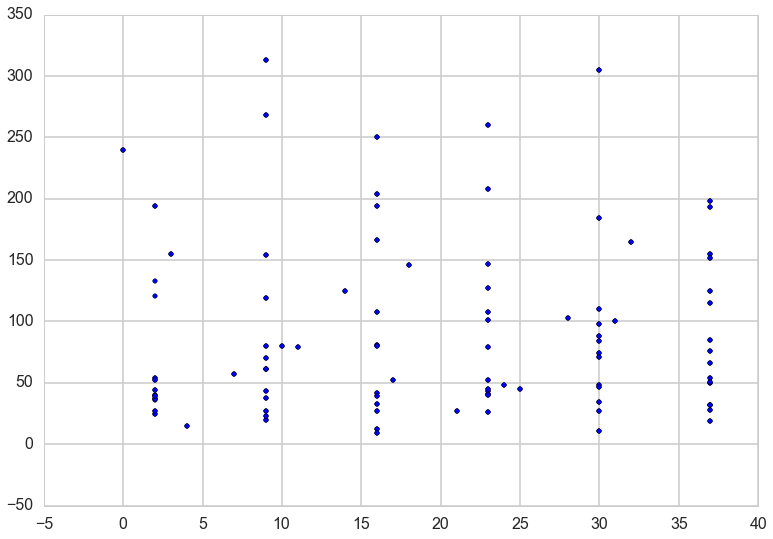

In [10]:
# A little EDA:
plt.scatter(fulldf["daysaway"], fulldf["lowest_price"])

print np.mean(fulldf["lowest_price"][fulldf["daysaway"] < 20])
print np.mean(fulldf["lowest_price"][fulldf["daysaway"] > 20])


In [ ]:
# OUTLINE:
# Short time horizon:
    # logistic for probability that appreciates more than x%
    # regression with y = final price after x days
# In order to extend to further time horizons without data, can regress today's price
    # get ceof. on days away
    # forecast by changing days away

In [11]:
print len(fulldf["avg_price"])
fulldf

189


,index,listing_count,avg_price,lowest_price_good_deal,lowest_price,highest_price,datetime_local,created_at,address,city,country,extended_address,venueid,venuename,postal_code,venuescore,venuestate,announce_date,short_title,datetime_utc,ticket_score,datetime_tbd,visible_until_utc,id,home_team,away_team,hometeamscore,awayteamscore,dateutc,timeutc,daysaway
0,0,2098,60.0,25,25,1124,2015-11-29T12:00:00,2015-04-22T00:00:00,1 Arrowhead Drive,Kansas City,US,"Kansas City, MO 64129",1128,Arrowhead Stadium,64129,0.89481,MO,2015-04-22T00:00:00,Bills at Chiefs,2015-11-29T18:00:00,0.82333,False,2015-11-29T22:00:00,2594346,Kansas City Chiefs,Buffalo Bills,0.79483,0.79211,2015-11-29,18:00:00,2
1,1,4578,79.0,38,38,5775,2015-12-06T13:00:00,2015-04-22T00:00:00,1 Bills Drive,Orchard Park,US,"Orchard Park, NY 14127",1135,Ralph Wilson Stadium,14127,0.90079,NY,2015-04-22T00:00:00,Texans at Bills,2015-12-06T18:00:00,0.84080,False,2015-12-06T22:00:00,2594531,Buffalo Bills,Houston Texans,0.79211,0.81340,2015-12-06,18:00:00,9
2,2,3384,174.0,81,81,670,2015-12-13T13:00:00,2015-04-22T00:00:00,1020 Pattison Avenue,Philadelphia,US,"Philadelphia, PA 19148",330,Lincoln Financial Field,19148,0.91513,PA,2015-04-22T00:00:00,Bills at Eagles,2015-12-13T18:00:00,0.87207,False,2015-12-13T22:00:00,2594419,Philadelphia Eagles,Buffalo Bills,0.82966,0.79211,2015-12-13,18:00:00,16
3,3,9183,183.0,26,26,1063,2015-12-20T13:00:00,2015-04-22T00:00:00,1600 Fedex Way,Landover,US,"Landover, MD 20785",35,FedEx Field,20785,0.95056,MD,2015-04-22T00:00:00,Bills at Redskins,2015-12-20T18:00:00,0.88619,False,2015-12-20T22:00:00,2594356,Washington Redskins,Buffalo Bills,0.84241,0.79211,2015-12-20,18:00:00,23
4,4,3529,180.0,98,98,5775,2015-12-27T13:00:00,2015-04-22T00:00:00,1 Bills Drive,Orchard Park,US,"Orchard Park, NY 14127",1135,Ralph Wilson Stadium,14127,0.90079,NY,2015-04-22T00:00:00,Cowboys at Bills,2015-12-27T18:00:00,0.87152,False,2015-12-27T22:00:00,2594529,Buffalo Bills,Dallas Cowboys,0.79211,0.88172,2015-12-27,18:00:00,30
5,5,5042,87.0,32,32,5775,2016-01-03T13:00:00,2015-04-22T00:00:00,1 Bills Drive,Orchard Park,US,"Orchard Park, NY 14127",1135,Ralph Wilson Stadium,14127,0.90079,NY,2015-04-22T00:00:00,Jets at Bills,2016-01-03T18:00:00,0.84746,False,2016-01-03T22:00:00,2594532,Buffalo Bills,New York Jets,0.79211,0.84751,2016-01-03,18:00:00,37
6,6,2283,91.0,36,36,1046,2015-11-29T13:00:00,2015-04-22T00:00:00,1 MetLife Stadium Drive,East Rutherford,US,"East Rutherford, NJ 07073",1587,MetLife Stadium,07073,0.96016,NJ,2015-04-22T00:00:00,Dolphins at Jets,2015-11-29T18:00:00,0.87448,False,2015-11-29T22:00:00,2594509,New York Jets,Miami Dolphins,0.84751,0.80367,2015-11-29,18:00:00,2
7,7,1676,185.5,61,61,1233,2015-12-06T13:00:00,2015-04-22T00:00:00,2269 NW 199th St,Miami Gardens,US,"Miami Gardens, FL 33056",29,Sun Life Stadium,33056,0.84595,FL,2015-04-22T00:00:00,Ravens at Dolphins,2015-12-06T18:00:00,0.82762,False,2015-12-06T22:00:00,2594468,Miami Dolphins,Baltimore Ravens,0.80367,0.79878,2015-12-06,18:00:00,9
8,8,1403,407.0,146,146,1391,2015-12-14T20:30:00,2015-04-22T00:00:00,2269 NW 199th St,Miami Gardens,US,"Miami Gardens, FL 33056",29,Sun Life Stadium,33056,0.84595,FL,2015-04-22T00:00:00,Giants at Dolphins,2015-12-15T01:30:00,0.85194,False,2015-12-15T05:30:00,2594469,Miami Dolphins,New York Giants,0.80367,0.85936,2015-12-15,01:30:00,18
9,9,4736,153.0,45,45,1213,2015-12-20T13:25:00,2015-04-22T00:00:00,9449 Friars Road,San Diego,US,"San Diego, CA 92108",1134,Qualcomm Stadium,92108,0.90643,CA,2015-04-22T00:00:00,Dolphins at Chargers,2015-12-20T21:25:00,0.87014,False,2015-12-21T01:25:00,2594374,San Diego Chargers,Miami Dolphins,0.83726,0.80367,2015-12-20,21:25:00,23


In [12]:
fulldf.shape[0]

189